# Evaluating a Trained Inception Model

In this tutorial, we'll take the checkpoint files emitted during training and use them to classify novel data that were not used during training. For most folks, this is the desired goal.

During this tutorial, we'll do the following:

 - Load test data not seen during training
 - Build an instance of the Inception architecture for evaluation
 - Evaluate the accuracy of our trained model
 - Collect incorrectly predicted test data for visualization

Note: This Jupyter notebook and its associated code are _heavily_ adapted from the published [Inception implementation](https://github.com/tensorflow/models/tree/master/inception). I've extracted pieces of the `imagenet_eval` Bazel task to better illustrate how one would evaluate an inception model just pure python.

Also, I wasn't trying to get to state of the art performance for MNIST classification so my training checkpoint isn't fully converged and only gets to 99.05% accuracy. YMMV!

**Pitfalls:**

 - Note that Inception expects input of Nx299x299x3, so make sure your inputs are appropriately scaled. See the `resize_images` method
 - If you're evaluating the model on a different machine than your training machine, the checkpoint directory (`CHECKPOINT_DIR`) must be the same as where your checkpoint files were outputted. Not sure why.


In [1]:
# Location of checkpoint directory from training
CHECKPOINT_DIR = "/tmp/mnist-inception"

# Number of classes (MNIST = 10, 1 for each digit)
NUM_CLASSES = 10

# Number of test images to evaluate at a time. Adjust to smaller if you're
# evaluation on a memory-constrained box
BATCH_SIZE = 20

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import time
import numpy as np
import tensorflow as tf
import inception_model as inception

from matplotlib import pyplot as plt, rcParams
from mpl_toolkits.axes_grid1 import ImageGrid
from scipy.ndimage.interpolation import zoom
from tensorflow.examples.tutorials.mnist import input_data

rcParams['figure.figsize'] = 20, 15

In [3]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

MEAN = np.mean(mnist.train.images)
STD = np.std(mnist.train.images)
NUM_TRAIN = mnist.train.labels.shape[0]
NUM_TEST = mnist.test.labels.shape[0]

print("Found %d training examples, %d test examples" % (NUM_TRAIN, NUM_TEST))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Found 55000 training examples, 10000 test examples


In [4]:
# A convenience method of plotting MNIST images in a grid
def plot_img(img, title, grid, index):
    grid[index].imshow(img)
    grid[index].set_title(title, fontsize=8)
    grid[index].axes.get_xaxis().set_visible(False)
    grid[index].axes.get_yaxis().set_visible(False)

# A convenience method for resizing the 784x1 monochrome images into
# the 299x299x3 RGB images that the Inception model accepts as input
RESIZE_FACTOR = (299/28)
def resize_images(images, mean=MEAN, std=STD):
    reshaped = (images - mean)/std
    reshaped = np.reshape(reshaped, [-1, 28, 28, 1]) # Reshape to 28x28x1

    # Reshape to 299x299 images, then duplicate the single monochrome channel
    # across 3 RGB layers
    zoomed = zoom(reshaped, [1.0, RESIZE_FACTOR, RESIZE_FACTOR, 1.0])
    zoomed = np.repeat(zoomed, 3, 3)

    return zoomed

## Constructing an Inception Instance for Evaluation

This method encapsulates the construction of an Inception model for evaluation. The number of output classes is set by the `NUM_CLASSES` parameter. The `build_inference` model uses the associated code (see: `inception_model.py`) to create an Inception computation graph, loads the weights and biases from the latest checkpoint, then returns the output of the model. 

In [5]:
def build_inference(sess, images, labels, checkpoint_dir):

    logits, _ = inception.inference(images, NUM_CLASSES + 1)

    variable_averages = tf.train.ExponentialMovingAverage(inception.MOVING_AVERAGE_DECAY)
    variables_to_restore = variable_averages.variables_to_restore()
    saver = tf.train.Saver(variables_to_restore)
    
    ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
    saver.restore(sess, ckpt.model_checkpoint_path)
    global_step = ckpt.model_checkpoint_path.split('/')[-1].split('-')[-1]
    print("Restored at step = %s" % (global_step))
    
    return logits

In [6]:
sess = tf.InteractiveSession()
images = tf.placeholder(tf.float32, shape=(None, 299, 299, 3))
labels = tf.placeholder(tf.float32, shape=(None, 1))

logits = build_inference(sess, images, labels, CHECKPOINT_DIR)

Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on their scope.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on their scope.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based 

## Evaluating Test Data in Batches

Here we'll loop over the `test` images from Tensorflow's included MNIST data set. It will loop over the test set, feeding successive batches of images to the Inception model created by `build_inference`. If you're evaluating your model on a separate machine (e.g., your laptop), you can adjust the `BATCH_SIZE` parameter to suit the memory constraints of your machine.

We'll also keep a running tally of how accurate our model is as it's evaluating and any test cases that the model didn't predict correctly . 

In [7]:
num_batches = NUM_TEST // BATCH_SIZE
bad_inds = []
bad_predictions = []

total_evaluated = 0
total_correct = 0
for index in xrange(num_batches):
    time_start = time.time()
    
    # Fetch the next batch, resize images and reshape labels to the appropriate shape
    raw_images, raw_labels = mnist.test.next_batch(BATCH_SIZE)
    batch_images = resize_images(raw_images)
    batch_labels = np.reshape(np.argmax(raw_labels, 1), (BATCH_SIZE, 1))
        
    # Use the Inception model to predict labels for this batch of test data
    result = sess.run(logits, feed_dict={ images: batch_images, labels: batch_labels })
    predicted_labels = np.argmax(result[:, 1:11], 1).reshape((BATCH_SIZE, 1))
    
    # Determine which predictsion were correct and keep a running tally of accuracy
    inds_incorrect = np.where(predicted_labels != batch_labels)
    n_correct = np.sum(predicted_labels == batch_labels)
    total_correct += n_correct
    total_evaluated += BATCH_SIZE
    accuracy = 100 * total_correct / total_evaluated
    
    # Save which test cases were predicted incorrectly for later visualization
    bad_inds.extend((index * BATCH_SIZE) + inds_incorrect[0])
    bad_predictions.extend(predicted_labels[inds_incorrect])
    
    if ((index % 50 == 0) or (index == (num_batches - 1))):
        elapsed = time.time() - time_start
        print("%3d: Elapsed: %4.1fs, Batch Correct = %2d, Total Correct = %5d, Total Evaluated = %5d, Acc = %7.3f%%" % (index, elapsed, n_correct, total_correct, total_evaluated, accuracy))

/usr/local/lib/python2.7/dist-packages/scipy/ndimage/interpolation.py:571: RuntimeWarning: invalid value encountered in true_divide
  zoom = (numpy.array(input.shape) - 1) / zoom_div


  0: Elapsed: 16.0s, Batch Correct = 20, Total Correct =    20, Total Evaluated =    20, Acc = 100.000%
 50: Elapsed: 13.6s, Batch Correct = 19, Total Correct =  1003, Total Evaluated =  1020, Acc =  98.333%
100: Elapsed: 14.1s, Batch Correct = 20, Total Correct =  1986, Total Evaluated =  2020, Acc =  98.317%
150: Elapsed: 14.6s, Batch Correct = 20, Total Correct =  2971, Total Evaluated =  3020, Acc =  98.377%
200: Elapsed: 14.2s, Batch Correct = 20, Total Correct =  3958, Total Evaluated =  4020, Acc =  98.458%
250: Elapsed: 13.9s, Batch Correct = 20, Total Correct =  4947, Total Evaluated =  5020, Acc =  98.546%
300: Elapsed: 14.4s, Batch Correct = 20, Total Correct =  5945, Total Evaluated =  6020, Acc =  98.754%
350: Elapsed: 14.3s, Batch Correct = 20, Total Correct =  6940, Total Evaluated =  7020, Acc =  98.860%
400: Elapsed: 15.1s, Batch Correct = 20, Total Correct =  7938, Total Evaluated =  8020, Acc =  98.978%
450: Elapsed: 14.6s, Batch Correct = 20, Total Correct =  8933, 

## Visualizing Incorrect Test Cases

Here we'll plot the test cases that our trained model predicted incorrectly. Some of these cases are actually quite difficult, even for a humange to distinguish. However, the trained model seems to have distinct trouble distinguishing between 6's and "loopy" 2's.

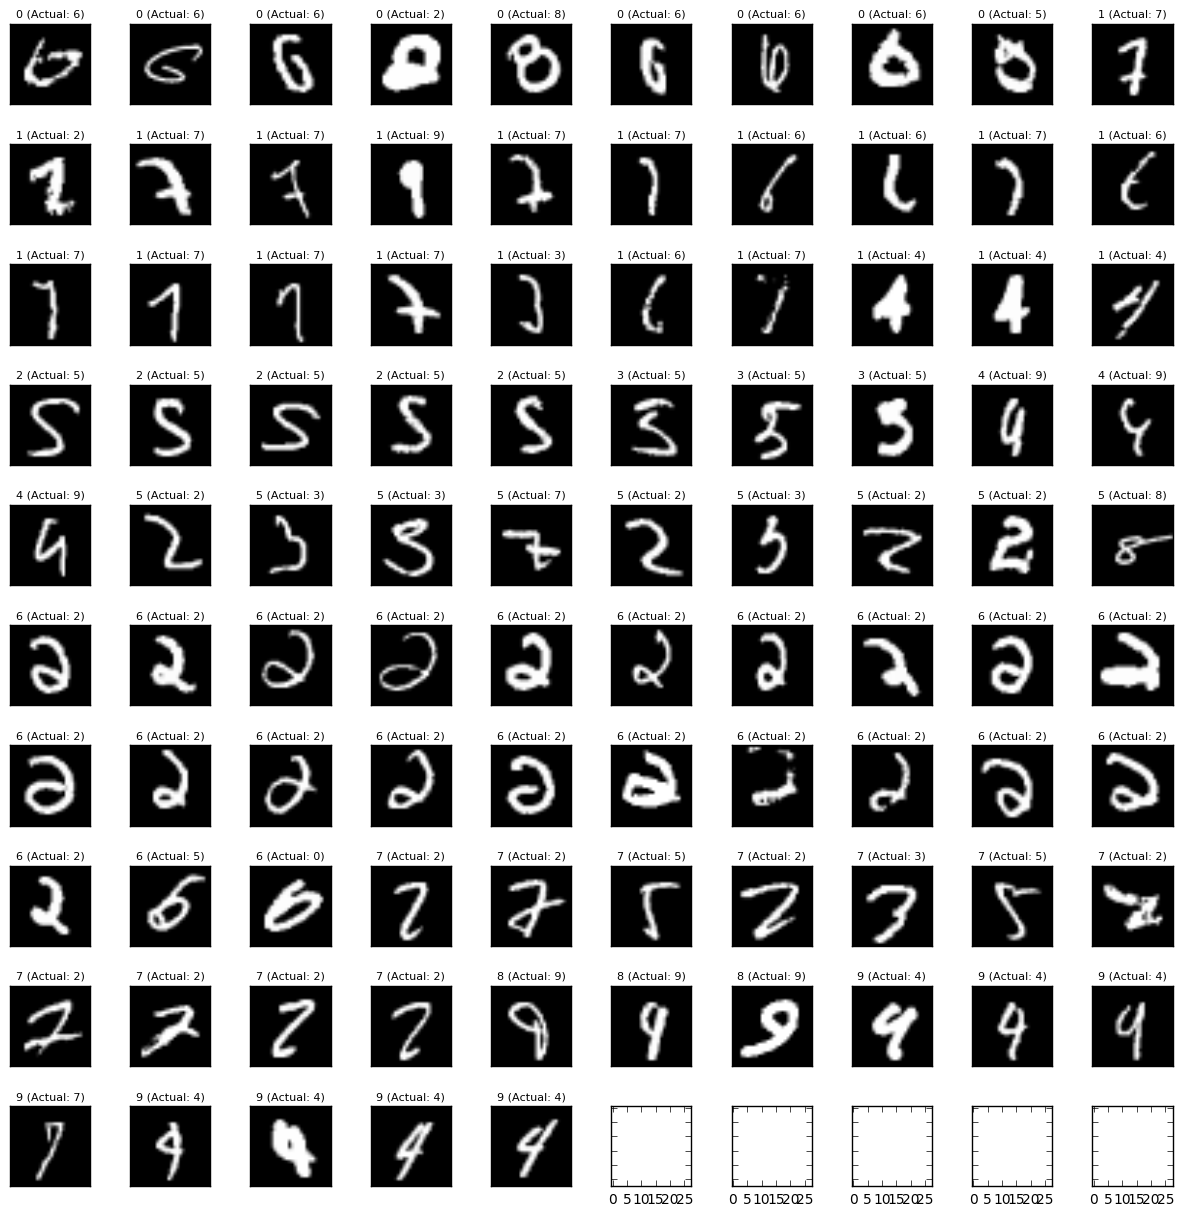

In [8]:
num_bad = len(bad_inds)
grid_width = 10
grid_height = (num_bad // grid_width) + 1
plt.set_cmap(plt.gray())
fig = plt.figure(1)
grid = ImageGrid(fig, 111, nrows_ncols=(grid_height, grid_width), axes_pad=0.4)

sorted_bad_inds = sorted(range(num_bad), key=lambda i: bad_predictions[i])

for i in xrange(num_bad):
    img_idx = bad_inds[sorted_bad_inds[i]]
    img = mnist.test.images[img_idx, :].reshape((28, 28))
    predicted_label = bad_predictions[sorted_bad_inds[i]]
    actual_label = np.argmax(mnist.test.labels[img_idx, :])
    
    label = "%d (Actual: %d)" % (predicted_label, actual_label)
    
    plot_img(img[:, :], label, grid, i)

plt.show()